<font size=5> Health Insurance Lead Prediction </font>

The competition aims to build a machine learning classification model to predict 'Probability of Customer showing interest' on Recommaded Health Insurance. It consist of demography data,Recommended Policy Information and prevoius Policy information. The model evalvation metric is roc-auc score. The data is some what imbalanced.

# Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as stats

plt.style.use('seaborn-whitegrid')
pd.set_option.max_columns=100

## Import dataset

In [2]:
train = pd.read_csv('input/train_Df64byy.csv')
test = pd.read_csv('input/test_YCcRUnU.csv')

strf = f"""
train shape {train.shape}
test  shape {test.shape}
"""
print(strf)


train shape (50882, 14)
test  shape (21805, 13)



## Glimse Data

In [3]:
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
test.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [5]:
d = {'train_unique':train.nunique(),'test_unique':test.nunique(),'train_na':train.isnull().mean(),
    'test_na':test.isnull().mean()}
pd.DataFrame(d)

,train_unique,test_unique,train_na,test_na
Accomodation_Type,2,2.0,0.000000,0.000000
City_Code,36,36.0,0.000000,0.000000
Health Indicator,9,9.0,0.229767,0.230543
Holding_Policy_Duration,15,15.0,0.397999,0.394543
Holding_Policy_Type,4,4.0,0.397999,0.394543
ID,50882,21805.0,0.000000,0.000000
Is_Spouse,2,2.0,0.000000,0.000000
Lower_Age,60,60.0,0.000000,0.000000
Reco_Insurance_Type,2,2.0,0.000000,0.000000
Reco_Policy_Cat,22,22.0,0.000000,0.000000


## Missing value

<AxesSubplot:>

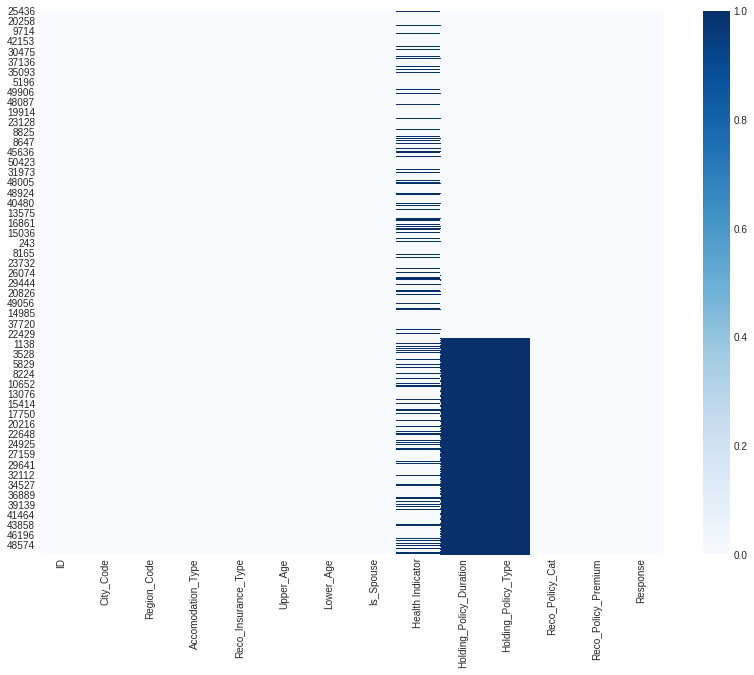

In [6]:
plt.figure(figsize=(14,10))
train1 = train.sort_values('Holding_Policy_Type')
sns.heatmap(train1.isnull(),cmap='Blues')

In [7]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

# Preprocess

In [8]:
# preprocess
train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].replace({'14+':15})
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].replace({'14+':15})

train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].fillna(0)
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].fillna(0)

train['Holding_Policy_Type'] = train['Holding_Policy_Type'].fillna('no_policy')
test['Holding_Policy_Type'] = test['Holding_Policy_Type'].fillna('no_policy')

In [9]:
train['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [10]:
most_freq = train['Health Indicator'].mode()[0]
train['Health Indicator'] = train['Health Indicator'].fillna(most_freq)
test['Health Indicator'] = test['Health Indicator'].fillna(most_freq)

In [11]:
id_col = ["ID"]
cat_col = ['Region_Code','City_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
'Is_Spouse', 'Health Indicator',  'Holding_Policy_Type', 'Reco_Policy_Cat', 'Holding_Policy_Duration',]
num_col = ['Upper_Age','Lower_Age','Reco_Policy_Premium']

train['Response'] = pd.Categorical( train['Response'])

## Statistical Analysis

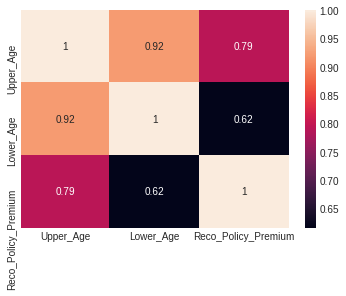

In [4]:
corr = train[num_col].corr()
sns.heatmap(corr,annot=True);

# Exploratory Data Analysis

## Distribution Plot

In [11]:
def num_plot(df,col,target=None,transform=None):
    """
    transform: log,log1p, log10, sqrt, square
    """
    f,ax = plt.subplots(1,2,figsize=(14,6))
    
    dfo = df[df[col].notnull()].reset_index(drop=True)
    # hist
    if transform is None:
        ax[0].hist(dfo[col],bins=50)
    else:
        dfo[col] = dfo[col].apply(transform)
        ax[0].hist(dfo[col],bins=50)
    ax[0].set_title(f'Distribution of {col}')
    
    # box plot
    if target is None:
        sns.boxplot(x=col,data=dfo,ax=ax[1])
    else:
        sns.boxplot(x=col,y=target,data=dfo,ax=ax[1])
    ax[1].set_title(f'Boxen plot of {col}')

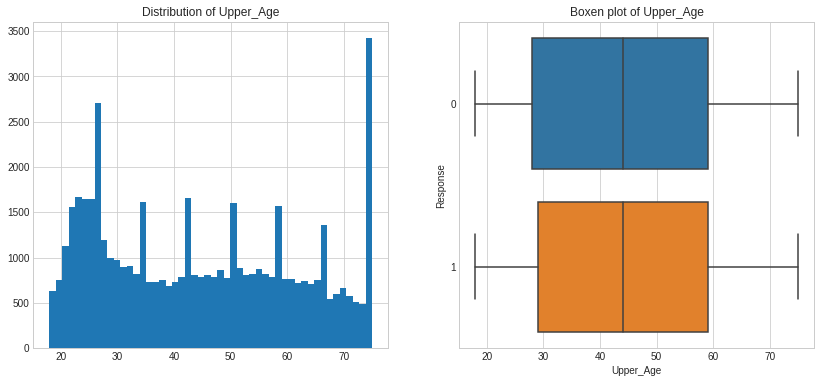

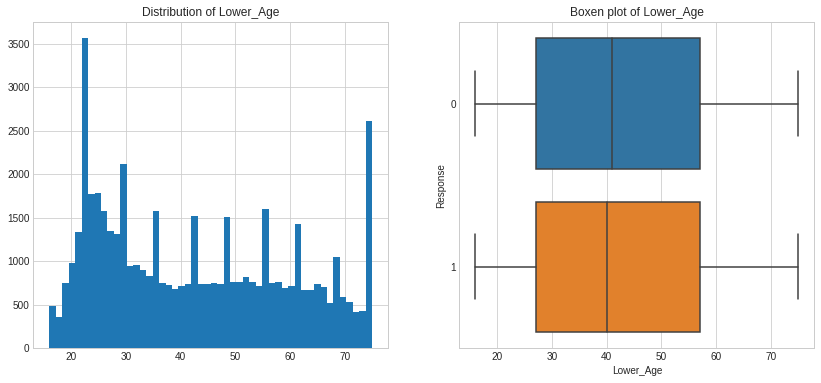

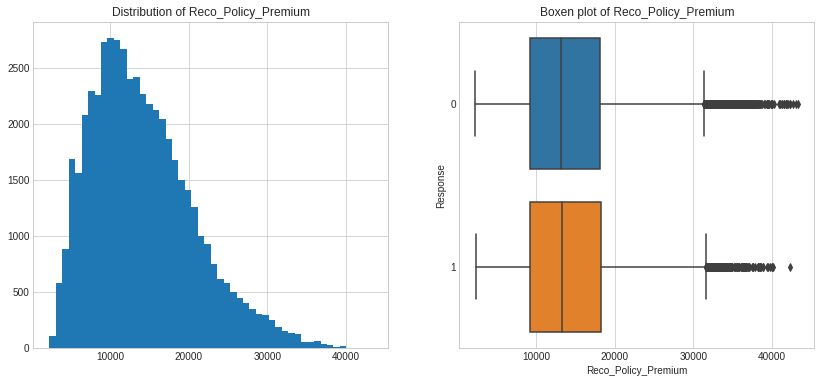

In [12]:
for col in num_col:
    num_plot(train,col,'Response')

In [13]:
#num_plot(train,'Reco_Policy_Premium','Response','sqrt')

## Categorical Plot

In [14]:
def cat_plot(df,col,heatmap=True,topN=20,xsize=14,ysize=6):
    """
    categorical plot
    """
    if heatmap:
        f,ax = plt.subplots(2,1,figsize=(xsize,ysize))
    else:
        f,ax = plt.subplots(1,1,figsize=(xsize,ysize))
        ax = [ax]
    
    dfo = df[df[col].notnull()].reset_index(drop=True)
    # hist
    tmp = (dfo.groupby([col])
        .agg(cnt=(col,'count'))
        .reset_index()
        .sort_values('cnt',ascending=False)[:topN]
        )
    tmp[col] = tmp[col].astype('str')
    sns.barplot(x=col,y='cnt',data=tmp,ax=ax[0])
    ax[0].set_title(f'Distribution of {col}')
    ax[0].tick_params(axis='y',direction='inout');
    
    if heatmap:
        pivot = (train.groupby(['Response',col])
                 .agg(Response=('Response','count'))
                 .unstack('Response'))
        sns.heatmap(pivot,annot=True,fmt='g',cmap='BuGn',ax=ax[1])
    f.tight_layout()

## Response

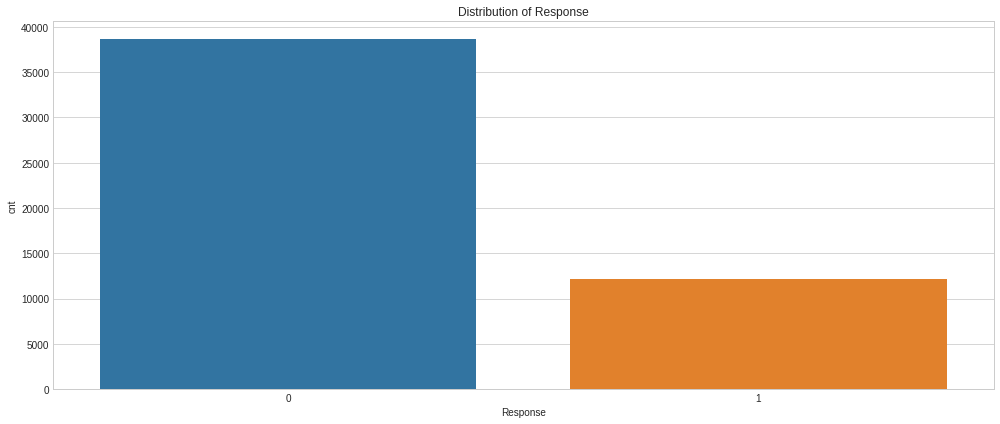

In [15]:
cat_plot(train,'Response',False)

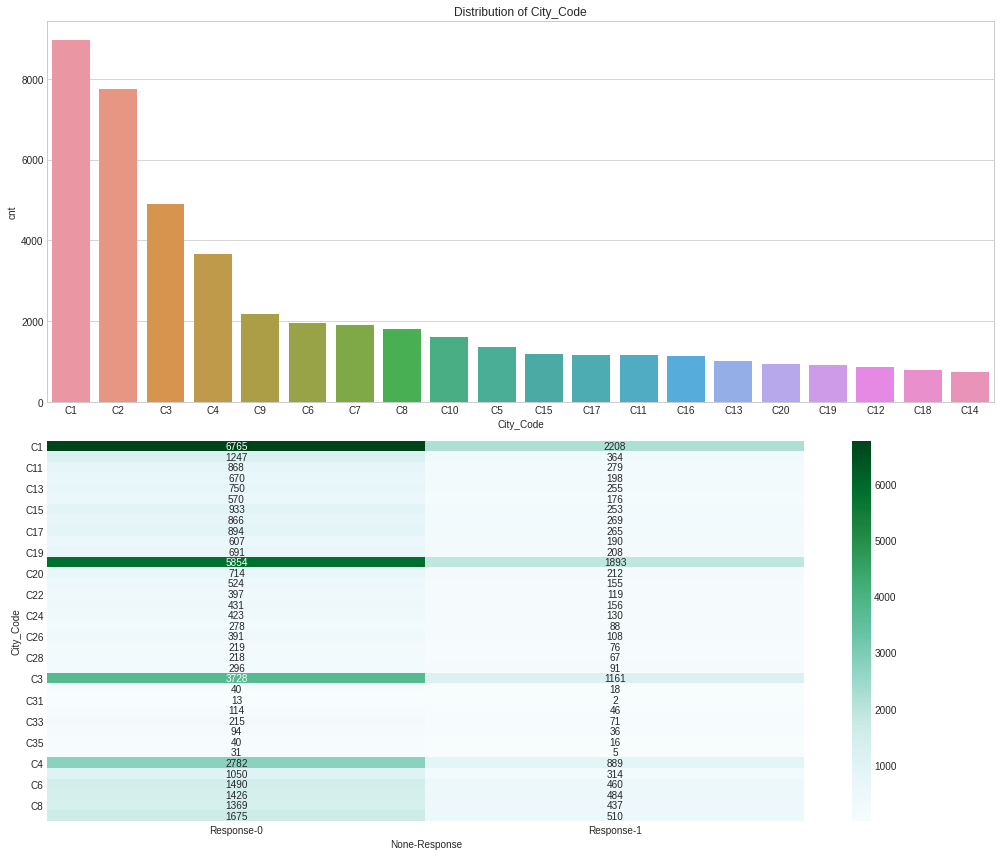

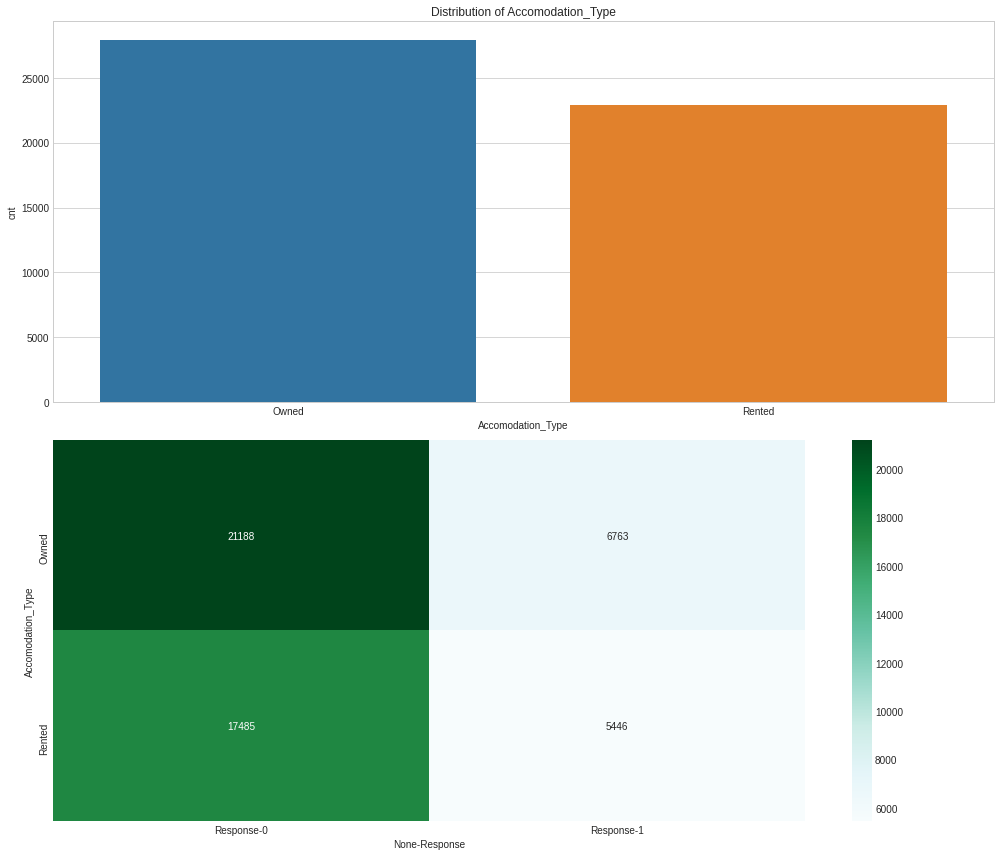

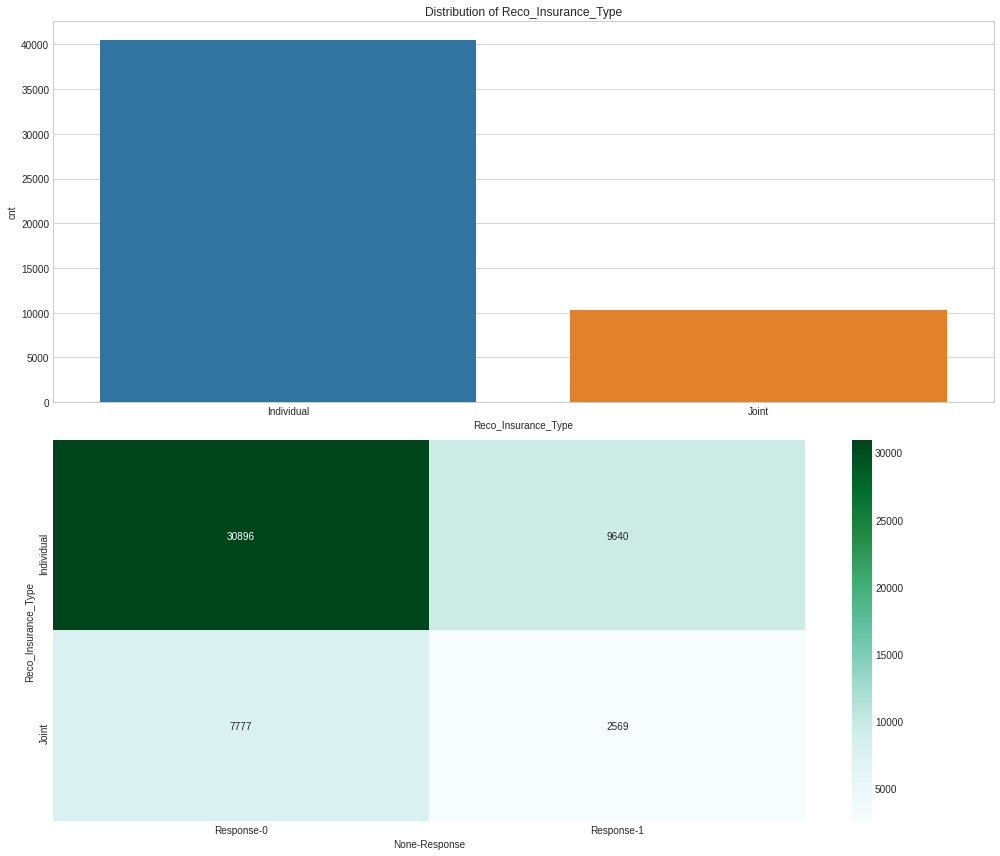

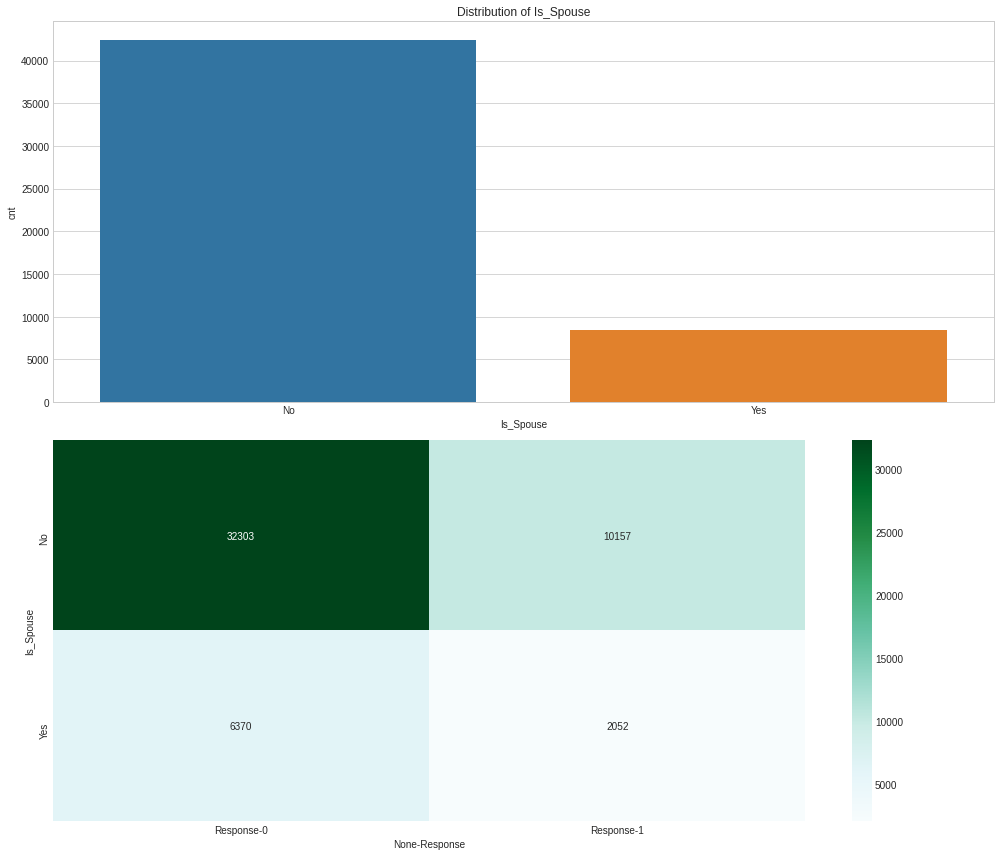

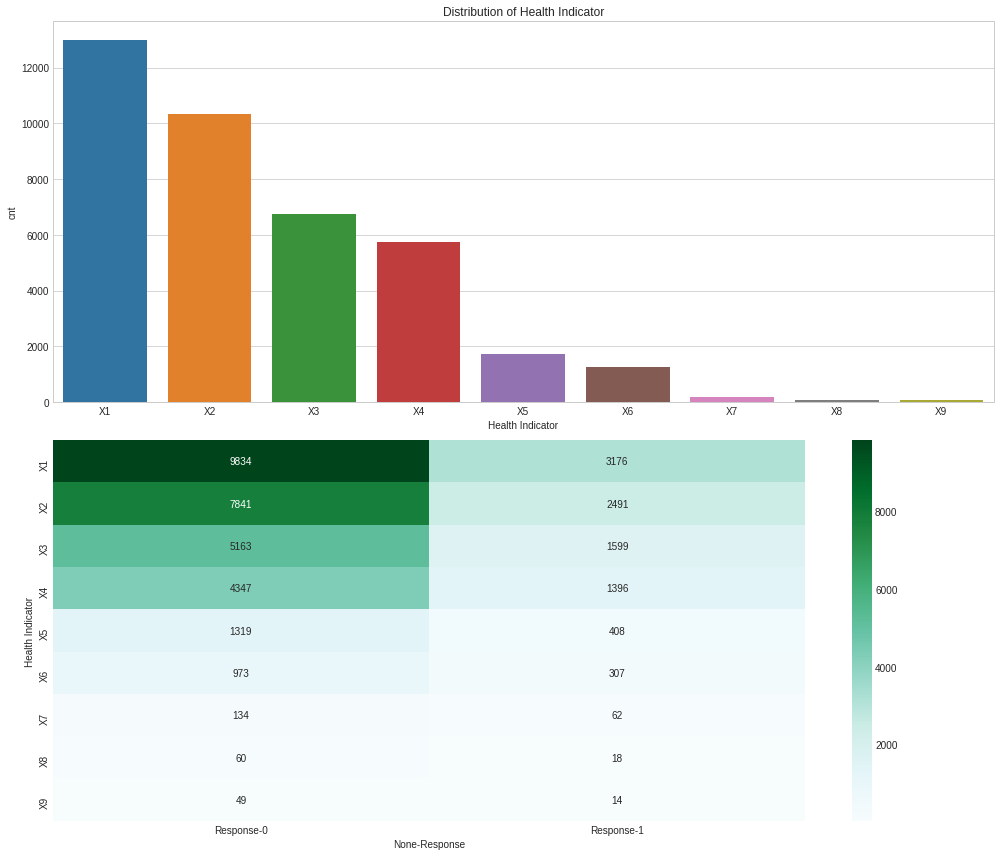

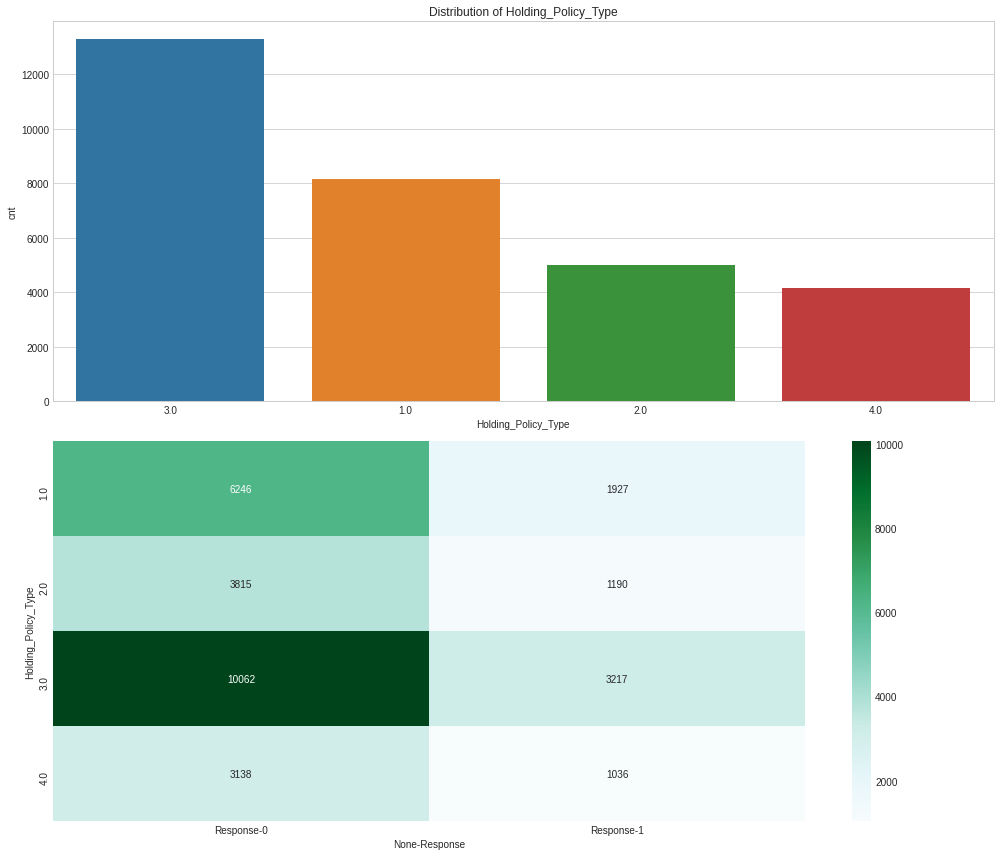

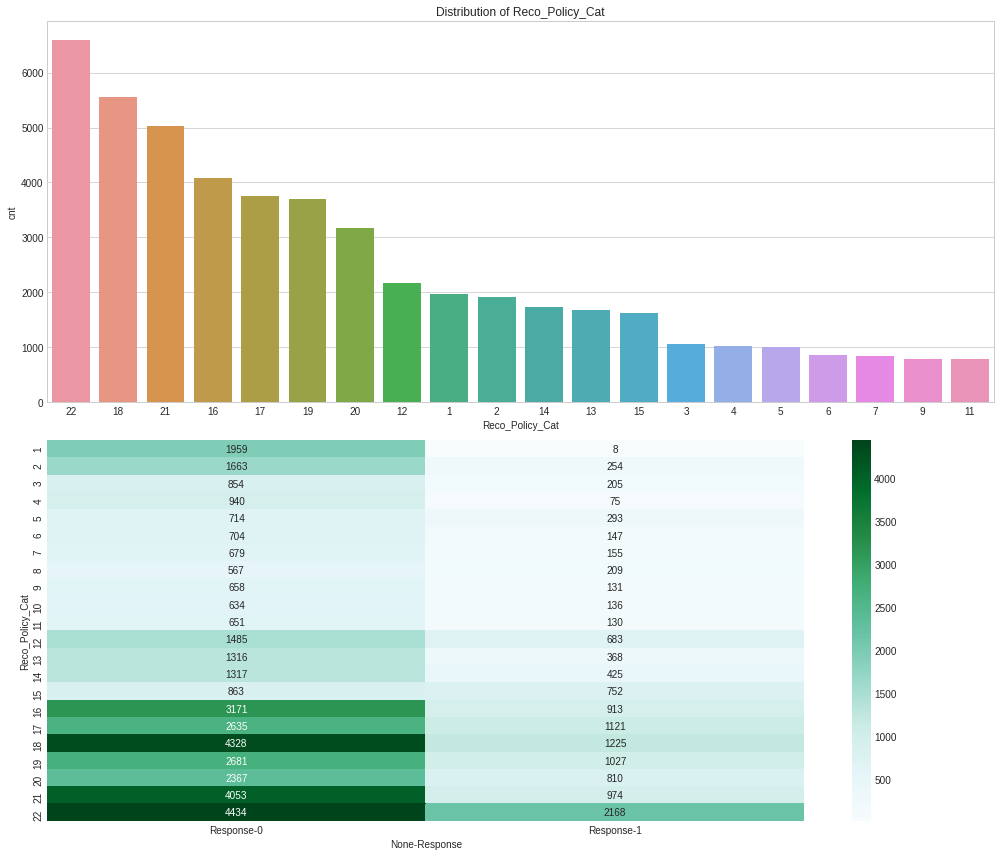

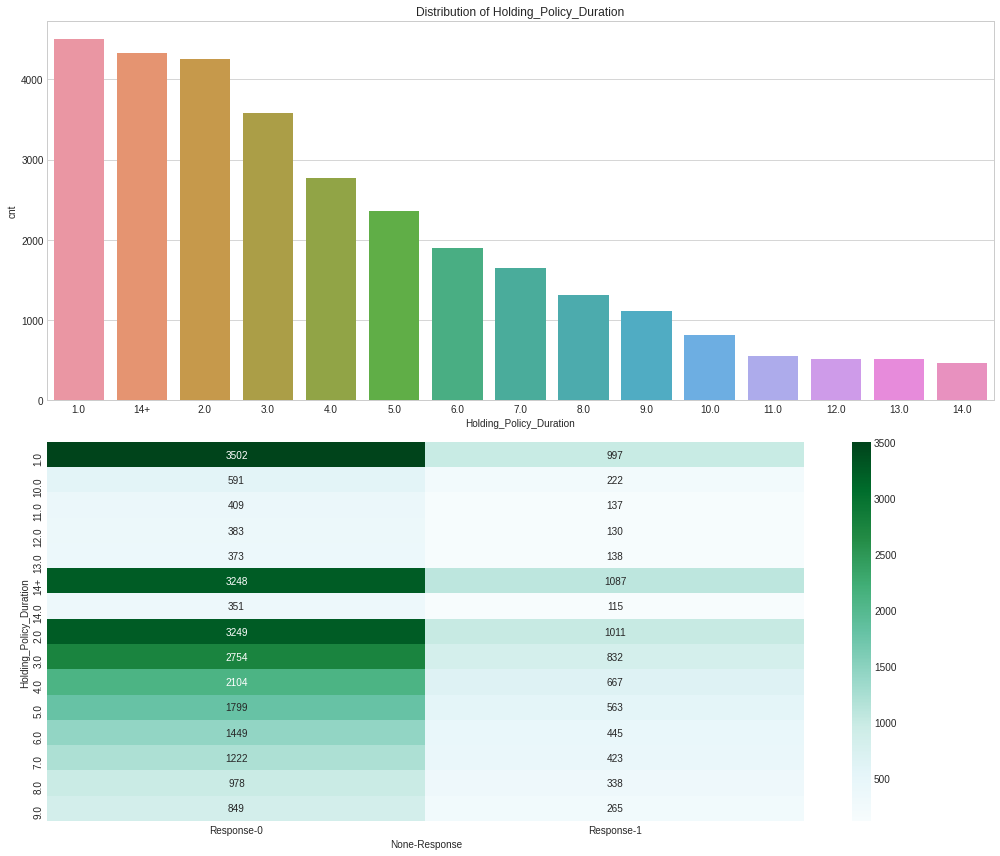

In [16]:
for c in cat_col[1:]:
    cat_plot(train,c,topN=20, xsize=14, ysize=12)

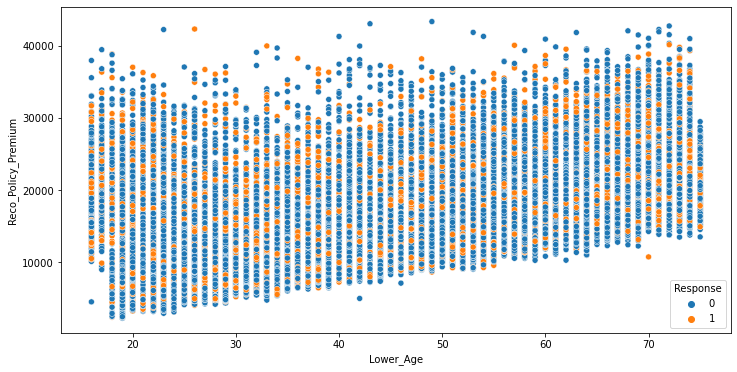

In [24]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Lower_Age',y='Reco_Policy_Premium',hue='Response',data=train);

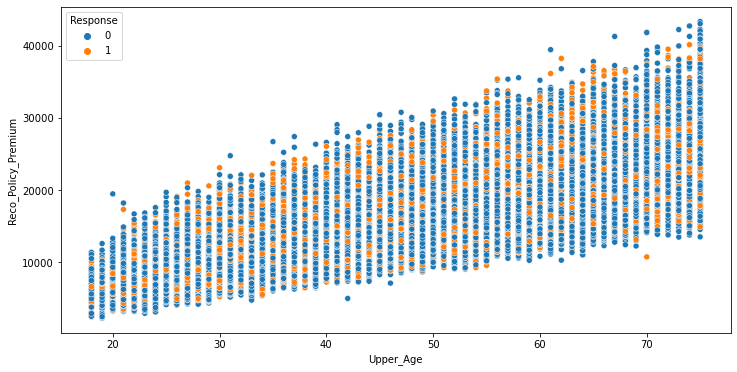

In [25]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Upper_Age',y='Reco_Policy_Premium',hue='Response',data=train);

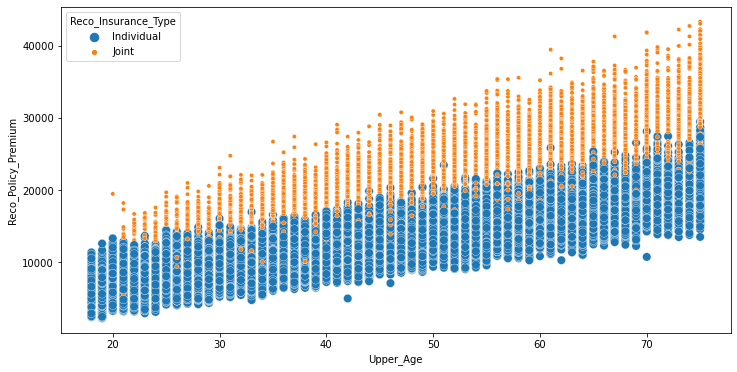

In [23]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Upper_Age',y='Reco_Policy_Premium',hue='Reco_Insurance_Type',data=train);

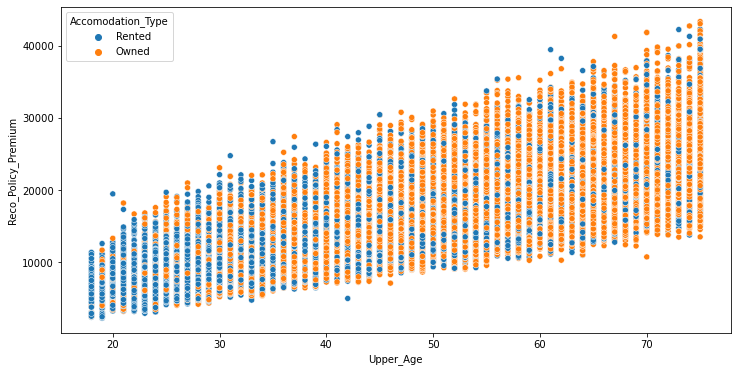

In [26]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='Upper_Age',y='Reco_Policy_Premium',hue='Accomodation_Type',data=train);

In [18]:
train1 = pd.get_dummies(train,columns=cat_col[1:],drop_first=True)
test1 = pd.get_dummies(test,columns=cat_col[1:],drop_first=True)

## LogisticRegression

In [19]:
# bench mark
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# model selection
X = train1.drop(['ID','Response'],axis=1)
y = train1['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
model = LogisticRegression(class_weight='balance',solver='newton-cg',random_state=43,max_iter=200)
model.fit(X_train,y_train)

/home/sudhir/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sudhir/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sudhir/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sudhir/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


LogisticRegression(class_weight='balance', max_iter=200, random_state=43,
                   solver='newton-cg')

In [21]:
from src.skmetrics import classifier_eval, plot_roc_cm

In [22]:
#auc = classifier_eval(model, X_train, X_test, y_train, y_test)

Accuracy: 0.758
AUC :	 0.624
Precision: 0.585
Recall:	 0.008


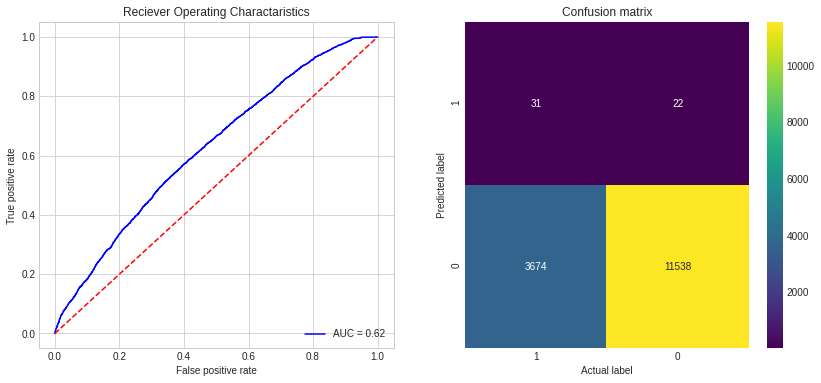

In [23]:
plot_roc_cm(model,X_test,y_test)

# Ensemble Model

In [24]:
import joblib
import lightgbm as lgb
model = joblib.load('models/lgbm_1.pkl')

In [25]:
df = pd.read_csv('input/train_folds.csv')

In [26]:
X_test= df.query('kfold == 1').drop(['Response','ID','kfold'],axis=1)
y_test= df.query('kfold == 1')['Response']

Accuracy: 0.775
AUC :	 0.751
Precision: 0.601
Recall:	 0.191


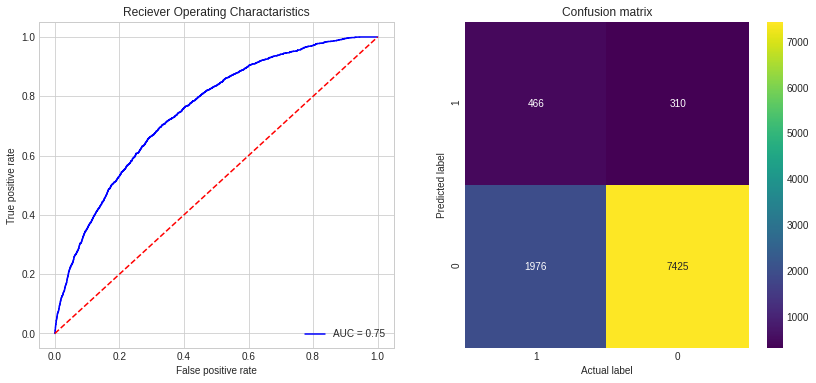

In [27]:
plot_roc_cm(model,X_test,y_test)

## Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

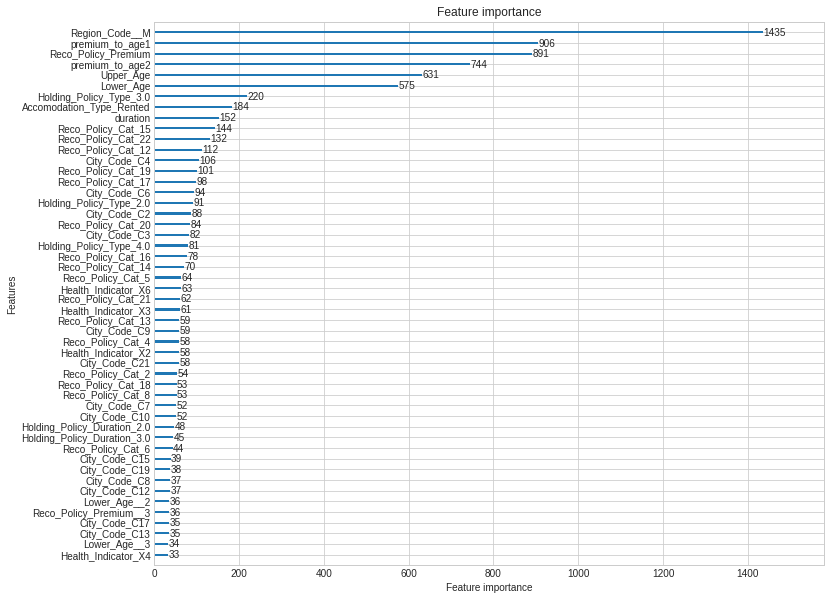

In [28]:
lgb.plot_importance(model,max_num_features=50,figsize=(12,10))

# Feature Engineering

In [31]:
df.columns.values

array(['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium', 'Region_Code__M',
       'premium_to_age1', 'premium_to_age2', 'duration',
       'Reco_Policy_Premium__2', 'Reco_Policy_Premium__3',
       'Reco_Policy_Premium__4', 'Reco_Policy_Premium__5', 'Lower_Age__2',
       'Lower_Age__3', 'Lower_Age__4', 'Upper_Age__2', 'Upper_Age__3',
       'Upper_Age__4', 'City_Code_C10', 'City_Code_C11', 'City_Code_C12',
       'City_Code_C13', 'City_Code_C14', 'City_Code_C15', 'City_Code_C16',
       'City_Code_C17', 'City_Code_C18', 'City_Code_C19', 'City_Code_C2',
       'City_Code_C20', 'City_Code_C21', 'City_Code_C22', 'City_Code_C23',
       'City_Code_C24', 'City_Code_C25', 'City_Code_C26', 'City_Code_C27',
       'City_Code_C28', 'City_Code_C29', 'City_Code_C3', 'City_Code_C30',
       'City_Code_C31', 'City_Code_C32', 'City_Code_C33', 'City_Code_C34',
       'City_Code_C35', 'City_Code_C36', 'City_Code_C4', 'City_Code_C5',
       'City_Code_C6', 'City_Code_C7', 'City_Code_C8', 'City_Code_C9'

In [33]:
cols = ['Upper_Age', 'Lower_Age', 'Region_Code__M', 'premium_to_age1',
       'premium_to_age2', 'duration','Reco_Policy_Premium']

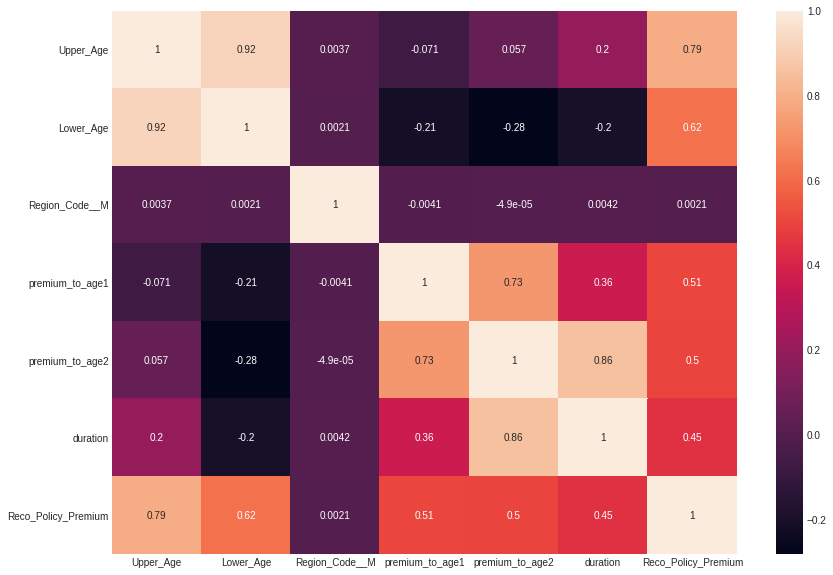

In [34]:
plt.figure(figsize=(14,10))
sns.heatmap(df[cols].corr(),annot=True);

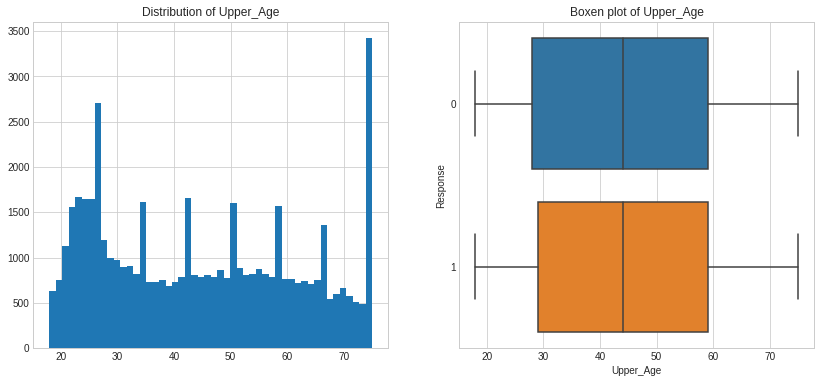

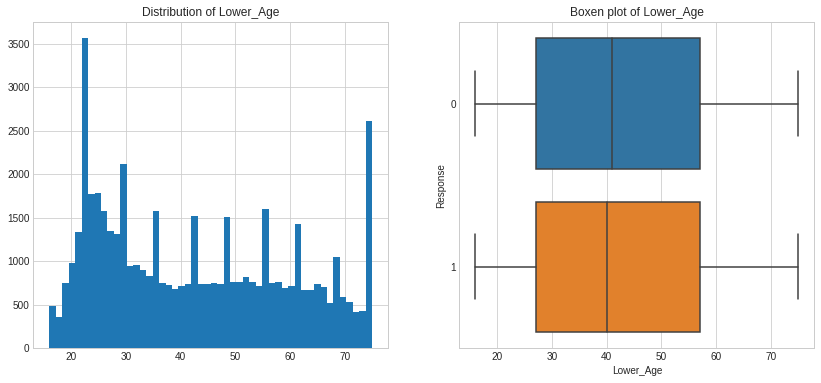

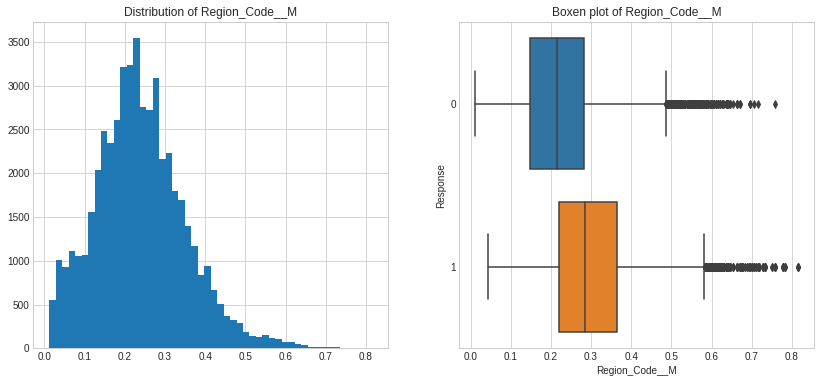

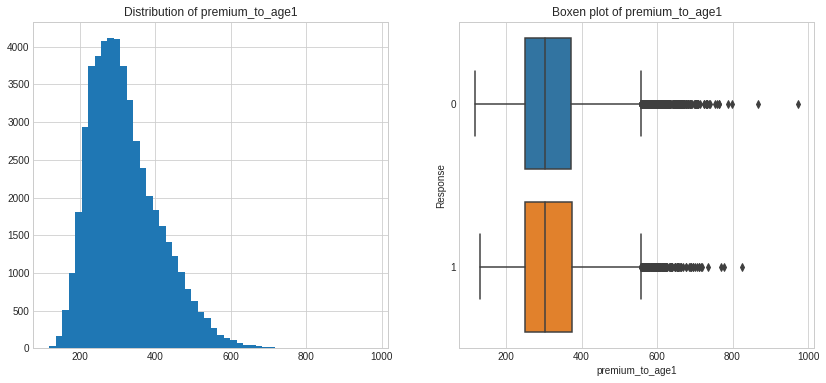

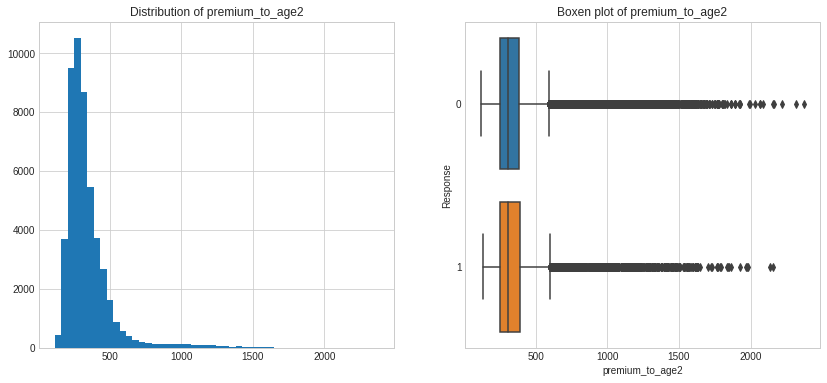

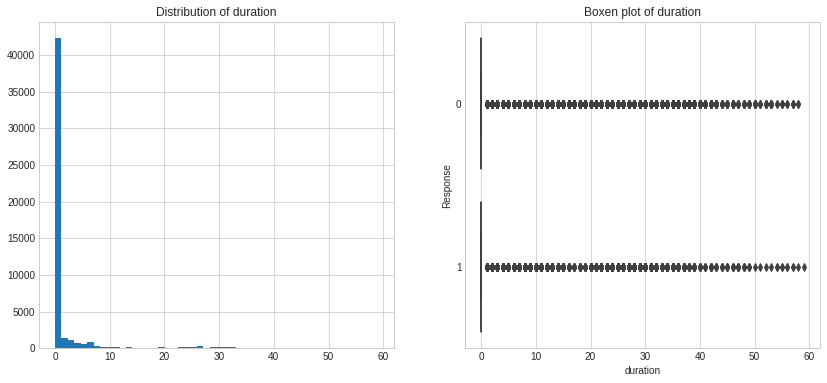

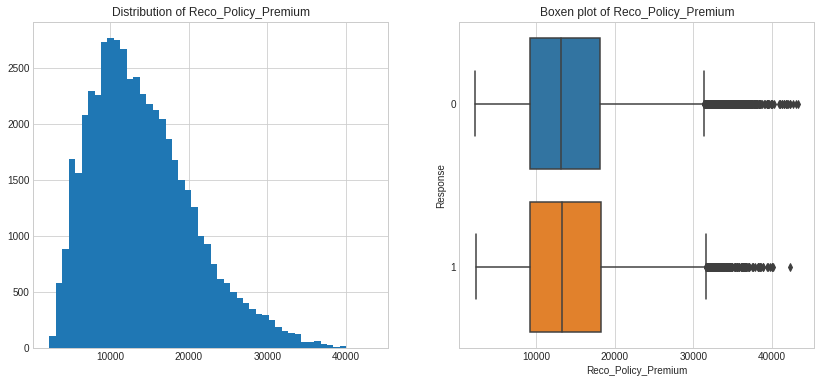

In [35]:
df['Response'] = pd.Categorical(df['Response'])
for col in cols:
    num_plot(df,col,'Response')

# Done